In [108]:
#93.8K Review File

from datasets import load_dataset

df = load_dataset(
    "ashraq/hotel-reviews",
    split='train'
).to_pandas()

In [109]:
# 1.

df["review"] = df["review"].str[:800]

df.head()

,review_date,hotel_name,review
0,8/3/2017,Park Plaza County Hall London,Extra bed was the worst breakfast queue was r...
1,8/3/2017,Park Plaza County Hall London,Just the location and view
2,8/3/2017,Park Plaza County Hall London,Around the corner from the London eye and use...
3,8/2/2017,Park Plaza County Hall London,I wish you had wheat free snacks
4,8/2/2017,Park Plaza County Hall London,You re always my hotel of choice You re staff...


In [110]:
# 2.

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [111]:

# 3.

from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"


model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
    )

In [112]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [113]:
test_review = df["review"][0]
test_review

' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a specific time though you have to arrange it somehow Parking is far away and hard to come back because of road diversions '

In [114]:
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.9065253138542175}]

In [115]:
# 4.

from sentence_transformers import SentenceTransformer

retriever = SentenceTransformer(
    'sentence-transformers/all-MiniLM-L6-v2',
    device=device
)
retriever

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [116]:
# 5.
import pinecone
from config import PINECONE_API_KEY, PINECONE_ENV

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV
)


In [117]:
index_name = "sentiment-mining"

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=384,
        metric="cosine"
    )

index = pinecone.Index(index_name)

In [118]:
# 6.

index_name = 'sentiment-mining'

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=384,
        metric="cosine"
    )

index = pinecone.Index(index_name)

In [119]:
# 7.

def get_sentiment(reviews):
    sentiments = nlp(reviews)
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [120]:
get_sentiment(df["review"][:3].tolist())

(['negative', 'neutral', 'positive'],
 [0.9065253138542175, 0.7716172933578491, 0.8975033760070801])

In [121]:
# 8.

import dateutil.parser

def get_timestamp(dates):
    timestamps = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamps

In [122]:
get_timestamp([df["review_date"][0]])[0]

1501707600.0

In [123]:
# 9.

from tqdm.auto import tqdm

start_index = 3840
batch_size = 128


for i in tqdm(range(start_index, len(df), batch_size)):
    i_end = min(i+batch_size, len(df))
    batch = df.iloc[i:i_end]
    emb = retriever.encode(batch["review"].tolist()).tolist()
    timestamp = get_timestamp(batch["review_date"].tolist())
    batch["timestamp"] = timestamp
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    meta = batch.to_dict(orient="records")
    ids = [f"{idx}" for idx in range(i, i_end)]
    to_upsert = list(zip(ids, emb, meta))
    _ = index.upsert(vectors=to_upsert)
 



  0%|          | 0/703 [00:00<?, ?it/s]

C:\Users\butil\AppData\Local\Temp\ipykernel_6412\2958818185.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["timestamp"] = timestamp
C:\Users\butil\AppData\Local\Temp\ipykernel_6412\2958818185.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
C:\Users\butil\AppData\Local\Temp\ipykernel_6412\2958818185.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [ ]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0384,
 'namespaces': {'': {'vector_count': 3840}},
 'total_vector_count': 3840}

In [ ]:
# 10.

query = "are the customers satisfied with the room sizes in London hotels?"

xq = retriever.encode(query).tolist()

result = index.query(xq, top_k=500, include_metadata=True)
result

{'matches': [], 'namespace': ''}

In [ ]:
result["matches"][:2]

[]

In [ ]:
# 11.

result["matches"][-2:]

[]

In [ ]:
def count_sentiment(result):
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    for r in result["matches"]:
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

sentiment = count_sentiment(result)
sentiment

{'negative': 0, 'neutral': 0, 'positive': 0}

<Axes: >

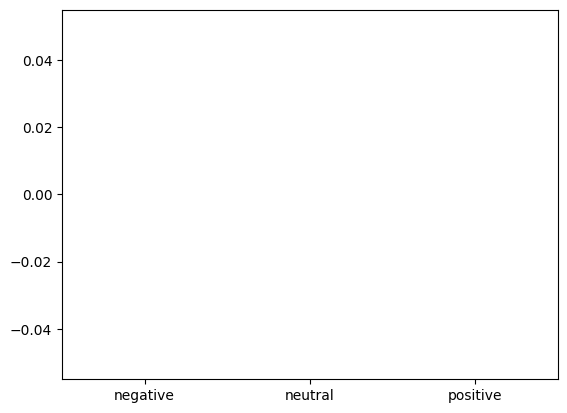

In [ ]:
# 12.

import seaborn as sns

custom_colors = ['red', 'orange', 'green']

sns.barplot(
    x=list(sentiment.keys()),
    y=list(sentiment.values()),
    palette=custom_colors,
    hue=list(sentiment.keys())
)

<Axes: >

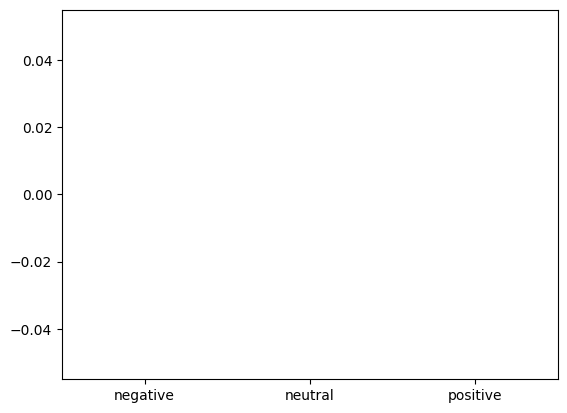

In [ ]:
# 13.

start_time = get_timestamp(["2015-12-25"])[0]
end_time = get_timestamp(["2015-12-31"])[0]

result = index.query(
    xq,
    top_k=500,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})

sentiment = count_sentiment(result)

sns.barplot(
    x=list(sentiment.keys()),
    y = list(sentiment.values()),
    palette=custom_colors,
    hue=list(sentiment.keys())
)

In [ ]:
# 14.

hotels =[
    "Strand Palace Hotel",
    "Britannia International Hotel Canary Wharf",
    "Grand Royale London Hyde Park",
    "Intercontinental London The O2",
]

queries = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC"
}

In [ ]:
# 15.

import matplotlib.pyplot as plt
import pandas as pd

hotel_sentiments = []

for hotel in hotels:
    result = []
    
    for area, query in queries.items():
        xq = retriever.encode(query).tolist()
        xc = index.query(xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel})
        
        sentiment = count_sentiment(xc)
        
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v 
            }
            
            result.append(data)
    
    hotel_sentiments.append({"hotel": hotel, "df": pd.DataFrame(result)})

In [ ]:
hotel_sentiments[0]["df"]

,area,label,value
0,Room Size,negative,0
1,Room Size,neutral,0
2,Room Size,positive,0
3,Cleanliness,negative,0
4,Cleanliness,neutral,0
5,Cleanliness,positive,0
6,Staff,negative,0
7,Staff,neutral,0
8,Staff,positive,0
9,Food,negative,0


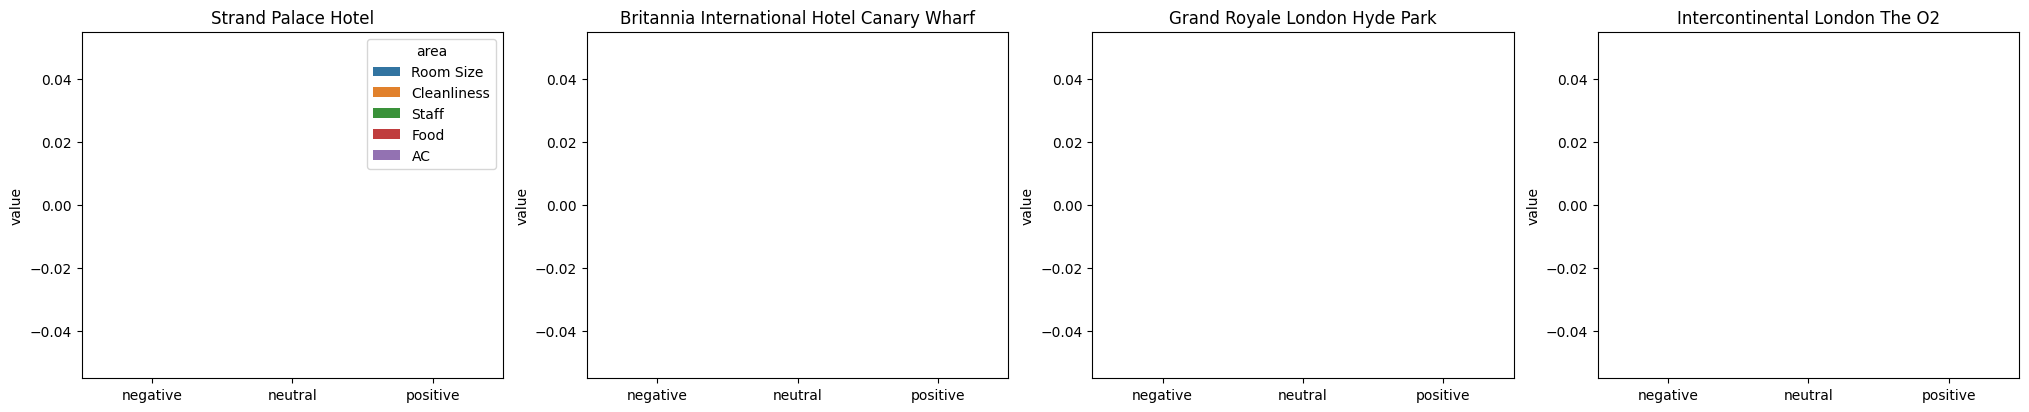

In [ ]:
# 16.

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 4.5))
plt.subplots_adjust(hspace=0.25)

counter = 0

for d, ax in zip(hotel_sentiments, axs.ravel()):
    sns.barplot(x="label", y="value", hue="area", data=d["df"], ax=ax)
    ax.set_title(d["hotel"])
    ax.set_xlabel("")
    counter += 1
    if counter != 1: ax.get_legend().remove()
plt.show()